Reference: https://www.kaggle.com/ozdemirh/feature-engineering-mlp-roc-curve-optimal-point

Reference: https://towardsdatascience.com/end-to-end-data-science-example-predicting-diabetes-with-logistic-regression-db9bc88b4d16

Pregnancies : 임신 횟수 , Number of times pregnant
glucose : 경구 포도당 내성 검사에서 2 시간 동안 혈장 포도당 농도, Plasma glucose concentration a 2 hours in an oral glucose tolerance test
BloodPressure : 이완기 혈압 (mm Hg), Diastolic blood pressure (mm Hg)
SkinThickness : 삼두근 피부 접힘 두께 (mm), Triceps skin fold thickness (mm)
insulin : 2 시간 혈청 인슐린 (mu U / ml), 2-Hour serum insulin test
BMI : 체질량 지수 (체중 kg / (높이 m) 2), Body mass index (weight in kg/(height in m)^2)
DiabetesPedigreeFunction : 당뇨병 혈통 기능 (가족력에 따라 당뇨병 가능성을 평가하는 기능)
age : 나이 (년)
outcome : 클래스 변수 (비 당뇨인 경우 0, 당뇨병 인 경우 1)

# 데이터 시각화 및 탐색 데이터 분석은 Pima Indians Phantine 데이터 세트에 대해 수행된다.
그 목적은 일련의 진단에 근거하여 환자가 당뇨병에 걸렸는지 여부를 예측하는 분류기를 만드는 것이다. 데이터를 정리한 후 다른 방법을 사용하여 형상의 중요도를 분석한다. MLP 분류기는 교차 검증을 통해 교육된다. 최적의 매개변수는 그리드 검색을 사용하여 찾을 수 있다. Scickit-learn을 사용하는 대신, 아래에 설명된 몇 가지 문제 때문에 우리는 자체적인 그리드 검색 기능을 쓸 것이다. 그리고 분류기의 roc 곡선을 그려서 최적의 작동 지점을 찾을 것이다. 마지막으로 kmapper를 이용해 각 feature의 중요성을 기준으로 분류해 어떤 feature가 당뇨병 여부를 판단하는데 가장 적합한지 알아보고 또한 클러스터 개수를 통해 당뇨병에 걸릴 정도를 클러스터별로 분석해보겠다. 

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

import xgboost as xgb
from xgboost import plot_importance

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt

import itertools

# Data Analysis and Visualization
CSV 파일은 pandas를 사용하여 로드된다. 데이터를 추출하여 데이터 프레임에 저장한다. 우리는 pandas head 기능을 사용하여 데이터 프레임의 상단 라인 및 컬럼 이름을 볼 수 있다. 관측할 라인 수는 head 기능에 대한 입력으로 지정할 수 있다.

In [3]:
data = pd.read_csv("insulin.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## data_X와 data_Y. 
data_X는 입력 피쳐 컬럼을 저장하고 data_Y는 출력 라벨 컬럼을 보유하면서 데이터프레임 컬럼은 두 부분으로 나뉜다. pandas info 기능을 이용해 컬럼 데이터 유형과 Null이 아닌 값의 개수를 관찰할 수 있다.

In [4]:
# disable SettingWithCopyWarning messages
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Outcome"]
data_Y = data[["Outcome"]]

print("\ndata_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()


data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Outcome  768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


## 요점, 주의사항
모든 입력 형상은 숫자형이다. 그리고 누락된 값은 없는 것 같다. 여기서 1점은 각별한 주의가 필요하다. 데이터 집합에서 결측값은 NaN 또는 NA 이외의 다른 값으로 인코딩될 수 있다. 예를 들어 데이터 집합의 일부 셀을 Na나 NAN으로 변경하여 다시 로드하고 정보를 확인하면 pandas는 이들을 null 값으로 인식하지 못한다. 그래서, pandas는 이 세포들이 없어진 것을 감지하지 못할 수도 있다. 우리의 경우 데이터 집합은 작으며 짧은 육안 검사로 결측값이 나타나지 않는다. 그러나 또 다른 요점이 있다. 일부 셀은 예상할 수 없는 입력으로 인코딩될 수 있다. 예를 들어, 0은 숫자 형상의 결측값을 나타낼 수 있다. 우리는 이 문제를 나중에 돌려줄 것이다.

output classes는 2개로 예상되고, 당뇨가 있거나 없는 것으로 예상된다. 아래 셀에서 클래스 수와 클래스 분포를 검사한다.

In [5]:
print(data_Y["Outcome"].value_counts())
sum(data_Y.values) / len(data_Y)

0    500
1    268
Name: Outcome, dtype: int64


array([0.34895833])

## 예상대로 두 개의 output classes가 있다. 

그들의 분포는 약 0.35:0.65로 심각한 불균형 문제를 일으키지 않는다.

이제, 우리는 데이터세트의 행을 train과 test로 두 부분으로 나눈다. 교차 검증을 통한 Training은 train set에서 수행되고 최종 시험은 test set에서 수행된다. train and test sets에서 클래스 분포를 동일하게 만들기 위해 층화된 k-fold 분할을 사용한다. 분할 후 클래스 분포를 출력하여 공정을 확인한다. 그리고 새로 만든 데이터 프레임의 인덱스를 재설정합니다. 그렇지 않으면 data_X 및 data_Y의 이전 인덱스를 사용하게 됩니다. 테스트 세트의 크기를 0.25로 설정하고 세미콜론을 사용하여 일부 라인의 출력을 억제합니다.

In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.25, stratify=data_Y, random_state=0)
print(sum(train_Y.values) / len(train_Y))
print(sum(test_Y.values) / len(test_Y))

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

[0.34895833]
[0.34895833]


## 이상치 찾기
이제 이상치가 있는지 찾아 볼 차례입니다. 이 노트에서는 이상치 탐지에 사 분위수 분석을 사용합니다. 각 feature에 대해 아래에 두 개의 플롯이 있으며, 왼쪽은 정규화 된 히스토그램이고 오른쪽은 플롯입니다. 두 가지를 함께 분석하여 이상치에 대한 아이디어를 얻습니다. 이상치를 제거한 후 데이터의 변화를 관찰하기 위해 두 개의 플롯이 다시 그려집니다.

상자 그림을 그리기 위해 feature 데이터는 4 개의 파트 또는 사 분위수로 나뉘며 각 샘플에는 동일한 수의 샘플이 있습니다. 분위수와 사 분위수를 혼동하기 쉽습니다. Quantile은 각각 동일한 수의 샘플을 갖는 데이터의 하위 집합으로 생각하십시오. 사 분위수는 특별한 Quantile 사례입니다. 데이터가 분기로 나뉘면 데이터는 사 분위수로 나뉩니다.

4로 나누려면 3 개의 절단 점이 필요합니다.이 절단 점은 하사 분위수 (또는 1 사 분위수), 중간 값 (또는 2 사 분위수) 및 상위 사 분위수 (또는 3 사 분위수)입니다. 두 번째 사 분위수는 지형지 물의 중앙값입니다. 1 분위는 2 분위보다 낮은 데이터의 중앙값입니다. 3 분위는 2 분위보다 데이터 강판의 중앙값입니다. 사 분위수 범위 (IQR)가 상위 사 분위수에서 하위 사 분위수를 뺀 것으로 확인되었습니다. 특이 치는 IQR과 상한 및 사 분위를 사용하여 결정됩니다.

seaborn 라이브러리를 사용하여 두 개의 하위 그림이 나란히 생성됩니다. 서브 플로트는 패드가있는 수평 분리 세트로 타이트한 레이아웃입니다. 이 시점부터 박스 플롯의 하단 수염은 LW로 표시되고 상단 수염은 UW로 표시됩니다.

### Pregnancies

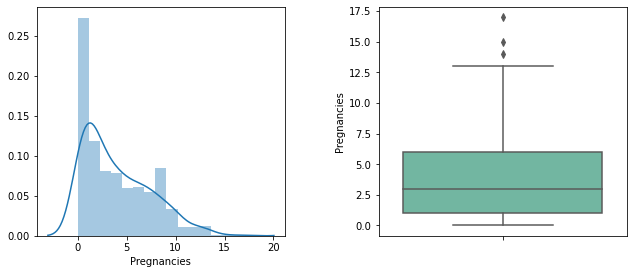

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Pregnancies"], ax=axes[0]);
sea.boxplot(train_X["Pregnancies"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

임신 기능의 경우 upper whisker 위의 일부 측정값이 있습니다. 이는 드문 사건으로 인한 것일 수 있습니다. 그것들을 이상치로 표시하고 UW 값으로 대체 할 수 있습니다.

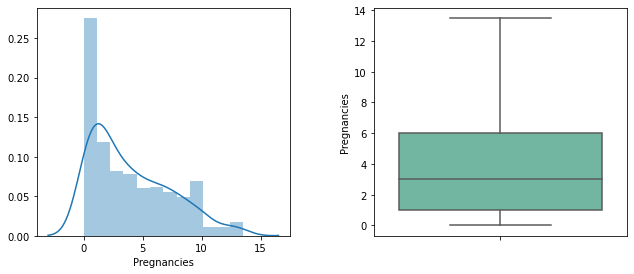

In [8]:
Q1 = train_X["Pregnancies"].quantile(0.25)
Q3 = train_X["Pregnancies"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Pregnancies"] = np.where(train_X["Pregnancies"] > UW, UW, train_X["Pregnancies"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Pregnancies"], ax=axes[0]);
sea.boxplot(train_X["Pregnancies"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

### Glucose

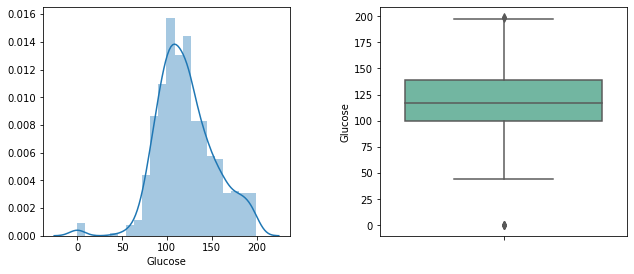

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Glucose"], ax=axes[0]);
sea.boxplot(train_X["Glucose"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

Glucose에는 0 값이 있으며 0에서 50 사이의 값은 없습니다. 누락 된 데이터의 자리 표시 자로 0 값을 간주 할 수 있습니다. 그래서 우리는 그것들을 이상치 (outlier)로 표시하고 그것들을 중앙값으로 대체 할 것입니다. 또한 UW보다 큰 값을 UW 값으로 바꿉니다.

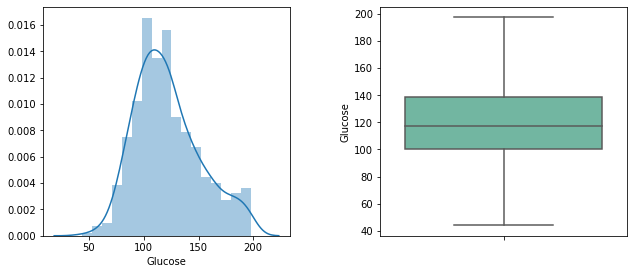

In [10]:
med = train_X["Glucose"].median()
train_X["Glucose"] = np.where(train_X["Glucose"] == 0, med, train_X["Glucose"])

Q1 = train_X["Glucose"].quantile(0.25)
Q3 = train_X["Glucose"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Glucose"] = np.where(train_X["Glucose"] > UW, UW, train_X["Glucose"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Glucose"], ax=axes[0]);
sea.boxplot(train_X["Glucose"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

### BloodPressure 

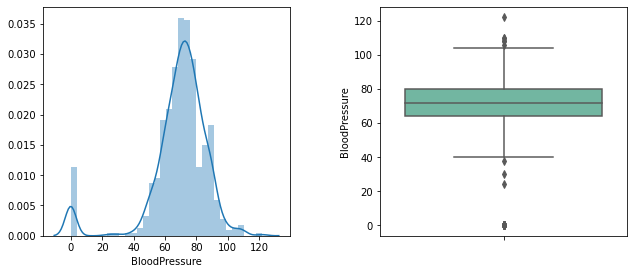

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["BloodPressure"], ax=axes[0]);
sea.boxplot(train_X["BloodPressure"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)


BloodPressure에 대한 0 값이 거의 없으며 0과 40 사이의 값이 없습니다. 0 값을 누락 된 데이터의 자리 표시 자로 간주 할 수 있습니다. 그래서 우리는 그것들을 이상치 (outlier)로 표시하고 그것들을 중앙값으로 대체 할 것입니다. 또한 LW보다 낮은 값 (0 제외)을 LW로 바꾸고 UW보다 큰 값을 UW로 바꿉니다.

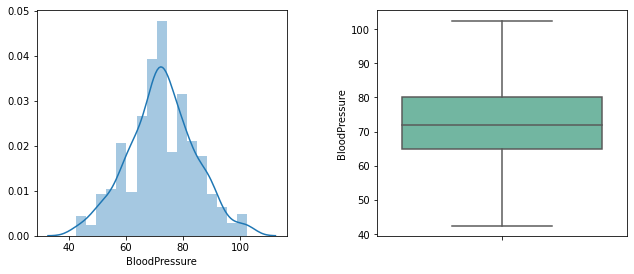

In [12]:
med = train_X["BloodPressure"].median()
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] == 0, med, train_X["BloodPressure"])

Q1 = train_X["BloodPressure"].quantile(0.25)
Q3 = train_X["BloodPressure"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR

train_X["BloodPressure"] = np.where(train_X["BloodPressure"] > UW, UW, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] < LW, LW, train_X["BloodPressure"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["BloodPressure"], ax=axes[0]);
sea.boxplot(train_X["BloodPressure"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

### SkinThickness 

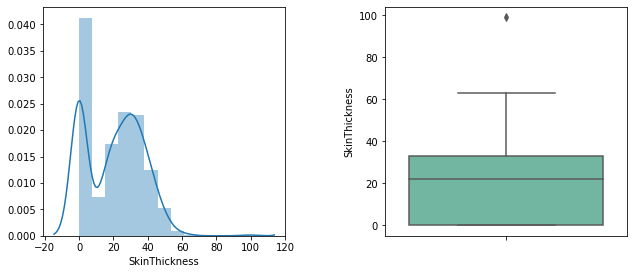

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["SkinThickness"], ax=axes[0]);
sea.boxplot(train_X["SkinThickness"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

SkinThickness에 대한 0 값이 거의 없습니다. 누락 된 데이터의 자리 표시 자로 0 값을 간주 할 수 있습니다. 그래서 우리는 그것들을 이상치 (outlier)로 표시하고 그것들을 중앙값으로 대체 할 것입니다. 또한 UW보다 큰 값을 UW로 바꿉니다.

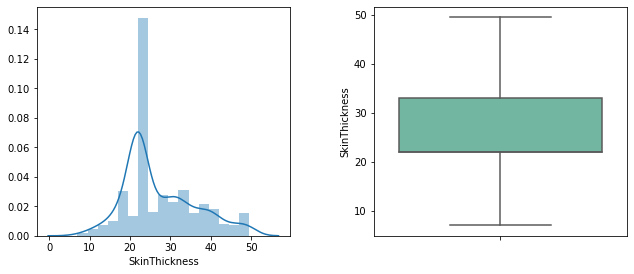

In [14]:
med = train_X["SkinThickness"].median()
train_X["SkinThickness"] = np.where(train_X["SkinThickness"] == 0, med, train_X["SkinThickness"])

Q1 = train_X["SkinThickness"].quantile(0.25)
Q3 = train_X["SkinThickness"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["SkinThickness"] = np.where(train_X["SkinThickness"] > UW, UW, train_X["SkinThickness"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["SkinThickness"], ax=axes[0]);
sea.boxplot(train_X["SkinThickness"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

### Insulin 

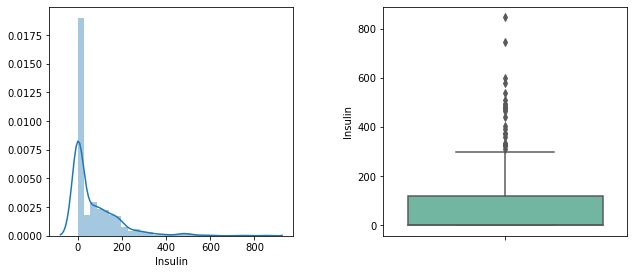

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Insulin"], ax=axes[0]);
sea.boxplot(train_X["Insulin"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

Insulin에 대한 0 값이 거의 없습니다. 누락 된 데이터의 자리 표시 자로 0 값을 간주 할 수 있습니다. 따라서 중앙값이 0이므로 이 값을 특이 값으로 표시하고 60 번째 백분위 수로 대체합니다. 또한 UW보다 큰 값을 UW로 바꿉니다.

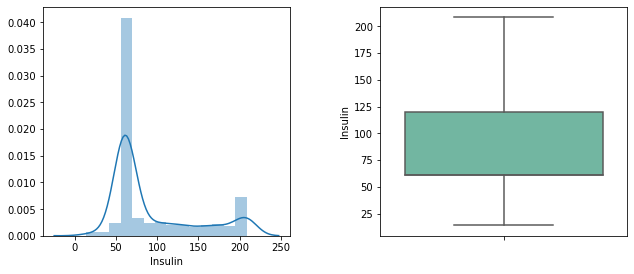

In [16]:
per_60 = train_X["Insulin"].quantile(0.60)
train_X["Insulin"] = np.where(train_X["Insulin"] == 0, per_60, train_X["Insulin"])

Q1 = train_X["Insulin"].quantile(0.25)
Q3 = train_X["Insulin"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Insulin"] = np.where(train_X["Insulin"] > UW, UW, train_X["Insulin"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Insulin"], ax=axes[0]);
sea.boxplot(train_X["Insulin"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

### BMI 

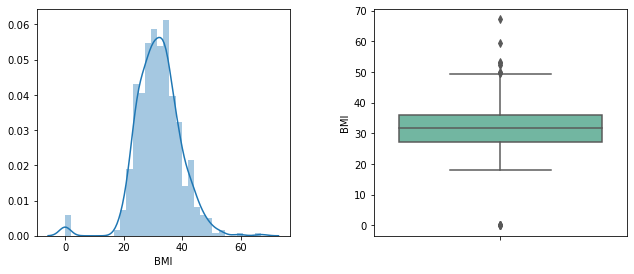

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["BMI"], ax=axes[0]);
sea.boxplot(train_X["BMI"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)


BMI에는 0 값이 있으며 0에서 20 사이의 값은 없습니다. 누락 된 데이터의 자리 표시 자로 0 값을 간주 할 수 있습니다. 그래서 우리는 그것들을 이상치 (outlier)로 표시하고 그것들을 중앙값으로 대체 할 것입니다. 또한 UW보다 큰 값을 UW로 바꿉니다.

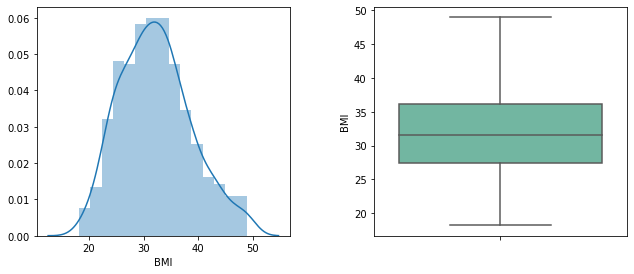

In [18]:
med = train_X["BMI"].median()
train_X["BMI"] = np.where(train_X["BMI"] == 0, med, train_X["BMI"])

Q1 = train_X["BMI"].quantile(0.25)
Q3 = train_X["BMI"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["BMI"] = np.where(train_X["BMI"] > UW, UW, train_X["BMI"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["BMI"], ax=axes[0]);
sea.boxplot(train_X["BMI"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

### DiabetesPedigreeFunction 

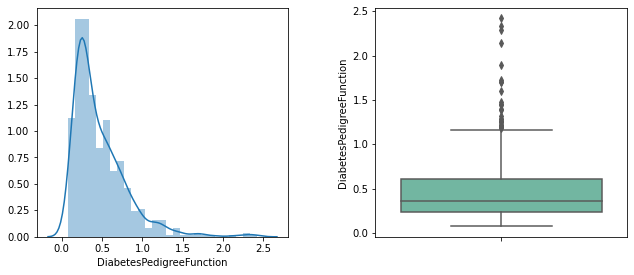

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["DiabetesPedigreeFunction"], ax=axes[0]);
sea.boxplot(train_X["DiabetesPedigreeFunction"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

UW보다 큰 값을 UW로 바꿉니다.

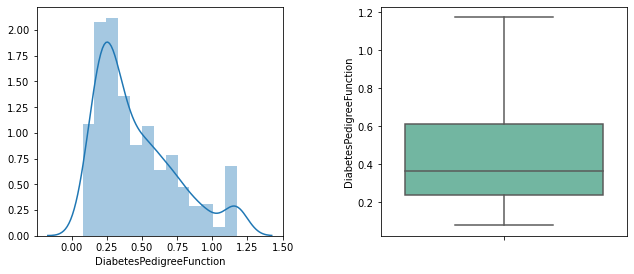

In [20]:
Q1 = train_X["DiabetesPedigreeFunction"].quantile(0.25)
Q3 = train_X["DiabetesPedigreeFunction"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["DiabetesPedigreeFunction"] = np.where(train_X["DiabetesPedigreeFunction"] > UW, UW, train_X["DiabetesPedigreeFunction"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["DiabetesPedigreeFunction"], ax=axes[0]);
sea.boxplot(train_X["DiabetesPedigreeFunction"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

### Age 

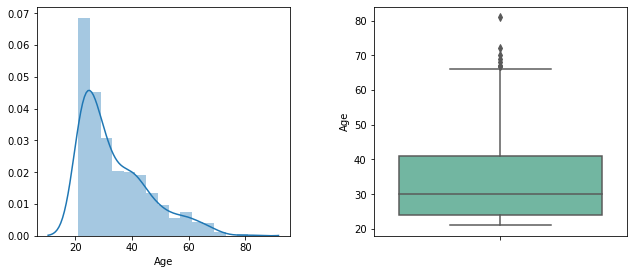

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Age"], ax=axes[0]);
sea.boxplot(train_X["Age"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

드문 이벤트로 인해 UW 이상의 측정이 있습니다. 우리는 그것들을 UW로 바꿀 것입니다.

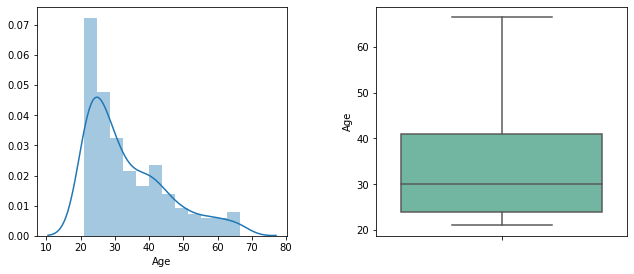

In [22]:
Q1 = train_X["Age"].quantile(0.25)
Q3 = train_X["Age"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Age"] = np.where(train_X["Age"] > UW, UW, train_X["Age"])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sea.distplot(train_X["Age"], ax=axes[0]);
sea.boxplot(train_X["Age"], orient="v", palette="Set2", ax=axes[1])

fig.tight_layout(pad=5.0)

## Classification
분류에는 MLP (Multi Layer Perceptron)를 사용합니다. 학습 성능을 높이기 위해 input features이 표준화되었습니다. feature의 평균 및 표준 편차가 계산됩니다. 그런 다음 feature의 각 샘플에서 평균을 빼고 결과를 표준 편차로 나눕니다. 목표는 feature을 평균 0과 표준 편차 1로 변환하는 것입니다. scikit-learn의 StandardScaler가 사용됩니다. StandardScaler는 train_X의 feature에 적합하며이 스케일러는 train_X 및 test_X의 동일한 feature을 변환합니다. 이 프로세스는 모든 features에 대해 반복됩니다.

In [23]:
for ind, column in enumerate(train_X.columns):
    scaler = StandardScaler()
    
    # fit to train data
    scaler.fit(train_X[[column]])
    
    # transform train data
    np_array = scaler.transform(train_X[[column]])
    train_X.loc[:, column] = pd.Series(np_array.flatten())
    
    # transform test data
    np_array = scaler.transform(test_X[[column]])
    test_X.loc[:, column] = pd.Series(np_array.flatten())

이제 feature 간 및 feature와 output 간의 선형 상관 관계를 검사합니다. Pandas corr 함수는 상관 행렬을 계산하는 데 사용되고 Seaborn 히트 맵은 plotting에 사용됩니다. seaborn 명령 끝에있는 세미콜론은 플롯 이외의 출력을 억제하는 데 사용됩니다. 상관 관계는 [-1,1] 간격이므로 색상 막대는 같습니다.
##상관분석은 두 변수의 값이 유의한 관계가 있는지, 즉 두 변수 값이 일관성을 갖고 변화하는지를 검토하기 위한 탐색적인 방법
##상관분석 설명 : https://bioinformaticsandme.tistory.com/58

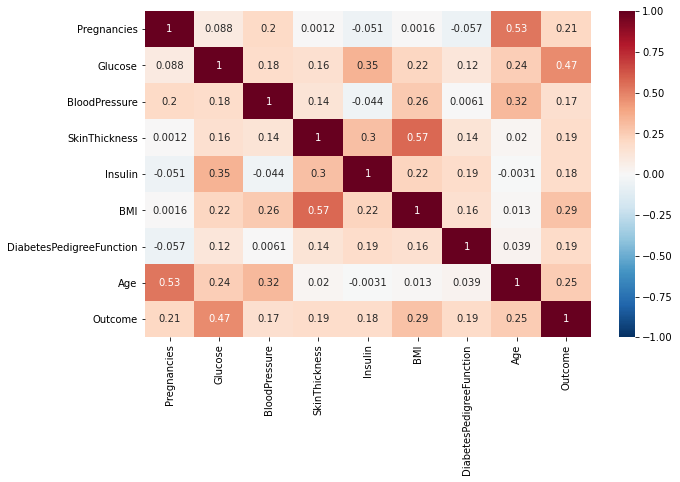

In [23]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
plt.figure(figsize=(10,6))
sea.heatmap(corr_matrix,annot=True,vmin=-1,vmax=1,center=0,cmap="RdBu_r");

상관 관계 매트릭스는 SkinThickness-BMI, Age-Pregnancies, Glucose-Insulin, BloodPressure-Age 사이에 가벼운 상관 관계가 있음을 보여줍니다. Outcome은 Glucose, BMI 및 Age와 가장 높은 선형 상관 관계를 갖습니다. Correlated input features은 기계 학습 모델의 학습 성능을 저하시킵니다. 다음 섹션에서는 feature importance에 대해 조사합니다. 일부 feature의 중요성이 무시할 수있는 경우 feature을 삭제하면 correlated inputs problem를 어느 정도 해결할 수 있습니다.

# Feature Importance

We use three types of methods to inspect feature importance:

Filter method : 위에서 한 것처럼 각 feature와 output 사이의 상관 계수와 같은 메트릭 계산. 이 방법에서는 모든 feature이 독립적으로 평가됩니다.

Embedded methods : 로지스틱 회귀 또는 선형 회귀와 같은 방법은 각 feature를 곱하는 계수를 학습합니다. 계수의 크기는 특징의 중요성과 관련이 있습니다. 또한 random forests 또는 gradient tree boosting과 같은 트리 기반 방법은 훈련 과정에서 feature의 중요성을 학습합니다. embedded methods에서는 모든 feature이 공동으로 평가됩니다.

##로지스틱 회귀(Logistic Regression)는 회귀를 사용하여 데이터가 어떤 범주에 속할 확률을 0에서 1 사이의 값으로 예측하고 그 확률에 따라 가능성이 더 높은 범주에 속하는 것으로 분류해주는 지도 학습 알고리즘이다 ; 설명 http://hleecaster.com/ml-logistic-regression-concept/

Wrapper methods : 기본적으로 추정기가 있고 subsets of features를 가지고 추정기를 훈련시킵니다. 최고 점수를주는 하위 세트가 선택되고 다른 feature들은 제거됩니다.

In [39]:
# logistic regression with l1 penalty - embedded method
lr1 = LogisticRegression(random_state=0, penalty="l1", class_weight="balanced", solver="saga", max_iter=5000)
lr1.fit(train_X, train_Y.values.ravel())
#coef_ == 추정된 가중치 벡터, 가중치가 클수록 중요한 feature이다(?)
lr1.coef_
#Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, 
#BMI, DiabetesPedigreeFunction, Age

array([[ 0.3964964 ,  1.07762339, -0.00247157,  0.        , -0.01570032,
         0.58691279,  0.33296671,  0.24303108]])

In [25]:
# logistic regression with l2 penalty - embedded method
lr2 = LogisticRegression(random_state=0, penalty="l2", class_weight="balanced", solver="saga", max_iter=5000)
lr2.fit(train_X, train_Y.values.ravel())

lr2.coef_

array([[ 0.40104592,  1.08313598, -0.02116736,  0.01132997, -0.0322987 ,
         0.5945656 ,  0.34131682,  0.25431702]])

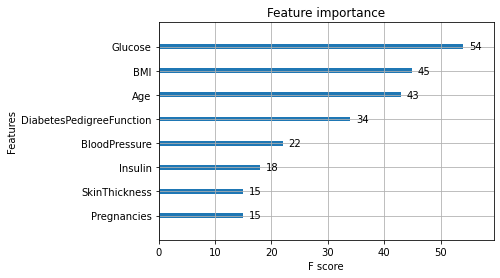

In [26]:
# xgboost - embedded method
gb = xgb.XGBClassifier(booster="gbtree",
                      learning_rate=0.15,
                      max_depth=4,
                      n_estimators=20)
gb.fit(train_X, train_Y.values.ravel())

plot_importance(gb);

In [27]:
# recursive feature elimination with logistic regression - wrapper method
lr3 = LogisticRegression(random_state=0, penalty="l2", class_weight="balanced", solver="saga", max_iter=5000)
rfe_lr3 = RFE(lr3, n_features_to_select=6)
rfe_lr3.fit(train_X, train_Y.values.ravel())

print(rfe_lr3.support_)

[ True  True False False  True  True  True  True]


특성에 표준화를 적용했기 때문에 로지스틱 회귀 계수의 크기는 각 특성의 중요성에 대한 아이디어를 제공합니다. 포도당과 BMI는 로지스틱 회귀 (l1 및 l2 포함) 및 xgboost에 가장 중요한 기능입니다. 이 결과는 상관 행렬과 일치합니다.

로지스틱 회귀 (l1 및 l2 포함)는 BloodPressure, SkinThickness 및 Insulin을 가장 덜 중요한 기능으로 표시합니다. L1 케이스에서 가장 중요하지 않은 특성에 대한 계수는 예상대로 0에 더 가깝습니다. 반면 xgboost는 임신, 피부 두께 및 인슐린을 가장 덜 중요한 기능으로 표시합니다.
따라서 공통적으로 생각되는 덜 중요한 기능은 SkinThickness와 Insulin입니다.

xgboost 결과의 원인에 대해서는 잘 모르겠지만, 그 이유는 나이와 임신이 어느 정도 상관 관계가 있기 때문일 수 있습니다. 그래서 xgboost는 일부 노드 분할에서 임신 대신 나이를 선택할 수 있습니다. 왜냐하면 Age는 Output과 더 높은 상관 관계를 갖기 때문입니다. 분할 수가 적다는 것은 중요성이 적다는 것을 의미합니다. 두 번째 이유는 xgboost가 기능과 출력 간의 비선형 관계를 캡처 할 수 있기 때문일 수 있습니다.

피쳐 수가 감소하면 모델의 복잡성도 감소합니다. 또한 특징이 적을수록 샘플 공간의 차원이 더 낮아지고 학습하려는 패턴을 적절하게 나타내는 데 필요한 샘플 크기가 감소합니다. 이것은 차원의 저주라는 현상과 관련이 있습니다. 따라서 중요하지 않은 기능을 삭제하여 학습 프로세스의 속도를 높이고 성능을 향상시킬 수 있습니다.

로지스틱 회귀와 xgboost에서 공통으로 생각되는 덜 중요한 기능 두 개를 아래 코드를 통해 삭제 하였습니다.

In [32]:
#train_X.drop("SkinThickness", axis=1, inplace=True)
#train_X.drop("Insulin", axis=1, inplace=True)

#test_X.drop("SkinThickness", axis=1, inplace=True)
#test_X.drop("Insulin", axis=1, inplace=True)

# Multi Layer Perceptron and Grid Search

##GridSearchCV 설명 ; https://datascienceschool.net/view-notebook/ff4b5d491cc34f94aea04baca86fbef8/

신경망 분류기는 scikit-learn MLP (Multi Layer Perceptron)를 사용하여 구현 될 수 있습니다. scikit-learn의 GridSearchCV를 사용하여 최적의 매개 변수를 찾을 수 있습니다. 이 매개 변수리스트의 데카르트 곱이 계산되고 각 매개 변수 세트로 별도의 모델이 학습됩니다. 교육 데이터는 교차 검증을 위해 분할로 분리됩니다. 그런 다음 GridSearchCV는 교차 검증 된 가장 높은 테스트 점수와 해당 매개 변수를 최상의 매개 변수 세트로 사용하여 최상의 추정기를 리턴합니다.

이 방법에는 세 가지주의 사항이 있습니다. 첫째, 1 스플릿의 최대 점수를 고려하여 최상의 추정기가 선택되지만 동일한 매개 변수로 다른 스플릿에서 훈련 된 추정기는 나쁜 결과를 반환 할 수 있습니다. 두 번째 문제는 분류 임계 값과 관련이 있습니다. GridSearchCV가 종료 된 후에는 추정자가 있지만 예측 된 확률을 클래스 예측으로 변환해야하는 임계 값이 없습니다. 세 번째 문제는 최상의 견적 도구가 전체 데이터에 대해 교육을받지 않았다는 것입니다.

이러한 문제를 해결하기 위해 자체 그리드 검색 코드를 작성합니다. 계층화 된 5 배 교차 검증을 사용합니다. 이는 동일한 클래스 분포로 5 개의 열차 테스트 스플릿이 있음을 의미합니다. 각 파라미터 세트는 5 개의 분할로 평가됩니다. 모델은 스플릿의 트레인 부분에서 학습되고 스플릿의 테스트 부분에서 검증됩니다. 이 과정은 5 번 반복됩니다. 따라서 각 매개 변수 세트에는 5 가지 모델이 있습니다. 5 개의 ROC 곡선은 예측 된 확률을 사용하여 그려집니다. ROC 곡선에서 최적의 작동 점을 찾을 수 있습니다.

ROC 곡선은 진 양성 비율 대 오 양성 비율의 도표입니다. 0과 1 사이의 서로 다른 임계 값의 경우 true 및 false 긍정 비율이 계산됩니다. 높은 정 양수 비율과 낮은 오 탐지율을 원하므로 ROC 곡선의 점을 (0,1)에 가장 가까운 지점을 최적의 작동 지점으로 설정할 수 있습니다. 람다 함수를 사용하여 (fpr, tpr) 튜플과 (0,1) 사이의 거리를 계산할 수 있습니다. map은 모든 (fpr, tpr) 튜플에 대해 람다를 실행합니다. 그런 다음 map 객체가 numpy argmin을 실행하도록 목록으로 변환됩니다. argmin은 거리가 가장 낮은 점의 인덱스를 반환합니다.

5 개의 모델에 대한 최적의 임계 값을 찾은 후 확률은 클래스 예측으로 변환되고 5 개의 정확도가 계산됩니다. 5 개의 분할 정확도를 사용하여 현재 매개 변수 세트에 대한 평균 정확도가 계산됩니다. 평균 임계 값은 동일한 방식으로 계산됩니다. 그리드 검색이 끝나면 각 매개 변수 조합에 대해 하나의 평균 정확도와 하나의 평균 임계 값이 있으며 가장 높은 평균 정확도를 제공하는 세트가 최고의 매개 변수 세트로 선택됩니다. 그리드 검색 및 교차 검증 중에 훈련 된 모든 모델이 삭제됩니다. 최종 분류기는 train_X에서 최상의 매개 변수로 학습됩니다.

검색 할 하이퍼 파라미터는 hidden_layer_sizes, alpha (L2 정규화 승수), batch_size 및 learning_rate_init (초기 학습 속도)입니다. hidden_layer_sizes는 튜플입니다. 그 길이는 숨겨진 층의 수를 제공하며 튜플의 각 항목은 해당 층의 뉴런 수를 결정합니다. 예를 들어 (50,50)은 두 개의 숨겨진 레이어를 나타내고 각각 50 개의 뉴런을 갖습니다.

adam 솔버는 10000 회 반복과 함께 사용됩니다. 활성화는 숨겨진 레이어 후 활성화 기능을 결정합니다. 출력 활성화 기능은 이진 분류를 위해 자동으로 물류로 설정됩니다.

In [ ]:
# convert dataframes to numpy arrays
np_train_X = train_X.values
np_train_Y = train_Y.values

# create stratified 5 fold
skf_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# list of hidden_layer_sizes
list_0 = [(50,100), (50, 100, 50)]

# list of alpha
list_1 = [0.003, 0.005, 0.007]

# list of batch_size
list_2 = [30, 50, 70]

# list of learning_rate_init
list_3 = [0.0003, 0.0005, 0.0007]

# accuracy array for 5 splits
split_accuracy = np.zeros(5, dtype = np.float64)

# threshold array for 5 splits
split_threshold = np.zeros(5, dtype = np.float64)

# initialization
best_params = ([(10)], 0.0001, 0.0001, 0.0001)
best_accuracy = 0.0
max_accuracy = 0.0
best_threshold = 0.5

i1 = 0
# iterate over the cartesian product of parameter lists
for prms in itertools.product(list_0, list_1, list_2, list_3):
    
    print("\nParameter set {}: {}".format(i1, prms))
    i1 = i1 + 1
    
    # create mlp classifier
    clf = MLPClassifier(solver="adam", max_iter=10000, activation = "logistic",
                        hidden_layer_sizes = prms[0],                      
                        alpha = prms[1],
                        batch_size = prms[2],
                        learning_rate_init = prms[3])

    print(" Split ", end="")

    i2 = 0
    # iterate over each split
    for train_ind, test_ind in skf_cv.split(np_train_X, np_train_Y):
        
        print("{} ".format(i2), end="")
        
        # get train and test set for this split
        train_fold_X, test_fold_X = np_train_X[train_ind], np_train_X[test_ind]
        train_fold_Y, test_fold_Y = np_train_Y[train_ind], np_train_Y[test_ind]
    
        # train mlp classifier
        clf.fit(train_fold_X, train_fold_Y.ravel())
    
        # get predicted probabilities for class 1
        y_proba = clf.predict_proba(test_fold_X)[:,1]

        # compute roc curve
        fpr, tpr, thr = roc_curve(test_fold_Y, y_proba)

        # compute optimal operating point and optimal threshold
        ind = np.argmin(list(map(lambda x, y: x**2 + (y - 1.0)**2, fpr, tpr)))
        
        # store optimal threshold of each split
        split_threshold[i2] = thr[ind]
        
        # compute class predictions with optimal threshold
        y_pred = [1 if x > thr[ind] else 0 for x in y_proba]
        
        # compute accuracy of each split and store in accuracy array
        split_accuracy[i2] = accuracy_score(test_fold_Y, y_pred)
        
        i2 = i2 + 1
        
    print(" , Mean split acc. {:.4f}".format(np.mean(split_accuracy)), end="")
    print(" , Max split acc. {:.4f}".format(np.max(split_accuracy)), end="")    
    print(" , Mean thr. {:.4f}".format(np.mean(split_threshold)), end="")    
     
    if (np.mean(split_accuracy) > best_accuracy):
        best_params = prms
        best_accuracy = np.mean(split_accuracy)
        max_accuracy = np.max(split_accuracy)
        best_threshold = np.mean(split_threshold)
    
print("\n\nBest parameters: {} ".format(best_params))
print("Best mean split test accuracy: {:.4f} ".format(best_accuracy))
print("Best split test accuracy: {:.4f} ".format(max_accuracy))
print("Best threshold: {:.4f} ".format(best_threshold))    

이제 최상의 parameter set와 최적의 임계 값을 갖습니다. 최종 분류자를 모든 training 데이터에 대해 train하고 이전에 분리 한 테스트 데이터에 대해 평가할 수 있습니다.
##ROC 커브 설명 ; https://yamalab.tistory.com/82 , https://losskatsu.github.io/machine-learning/stat-roc-curve/#%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80---roc-%EC%BB%A4%EB%B8%8C-%EA%B0%9C%EB%85%90-%EC%A0%95%EB%A6%AC

In [ ]:
# train final mlp classifier
clf = MLPClassifier(solver="adam", max_iter=10000, activation = "logistic",
                    hidden_layer_sizes = prms[0],                      
                    alpha = prms[1],
                    batch_size = prms[2],
                    learning_rate_init = prms[3])
clf.fit(np_train_X, np_train_Y.ravel())

# get predicted probabilities for class 1
y_proba = clf.predict_proba(test_X)[:,1]

# compute and plot roc curve
fpr, tpr, thr = roc_curve(test_Y, y_proba)
plt.plot(fpr, tpr, linestyle="-");
plt.title("ROC Curve");
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");

# compute optimal operating point and optimal threshold
ind = np.argmin(list(map(lambda x, y: x**2 + (y - 1.0)**2, fpr, tpr)))

# compute class predictions with optimal threshold
y_pred = [1 if x > thr[ind] else 0 for x in y_proba]

# compute accuracy
test_accuracy = accuracy_score(test_Y, y_pred)

print("Test accuracy: {:.4f} ".format(test_accuracy))

In [24]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               576 non-null    float64
 1   Glucose                   576 non-null    float64
 2   BloodPressure             576 non-null    float64
 3   SkinThickness             576 non-null    float64
 4   Insulin                   576 non-null    float64
 5   BMI                       576 non-null    float64
 6   DiabetesPedigreeFunction  576 non-null    float64
 7   Age                       576 non-null    float64
dtypes: float64(8)
memory usage: 36.1 KB


# Using k-mapper

 
 Data Mining은 방대한 양의 data로부터 유용한 지식(knowledge)을 추출해 내는 것인데, Database 또는 정형화되어 있지 않는 Data repository로부터 숨어있는 지식(hidden knowledge)을 추출하는 과정이다. 즉 방대한 정보로부터 암시적이고 사전에 알려지지 않은 유용한 정보를 추출하는 것이다. 예를 들어, 의사결정에 도움을 주기 위해 다양한 기술을 사용하여 자료들로부터 지식을 추출하여 의사결정지원, 예측, 추정과 같은 영역에 사용될 수 있도록 한다.
이번 project에서는 Pima Indians Diabetes Database로부터 의미 있는 정보를 추출하고자 한다. 이 data는 classification에 사용되는 data로 이미 많은 연구가 행해졌다[Smith et al. 1988]. 이 data는 diabetes 여부를 판단하기 위해서 행해진 8개 가지의 서로 다른 검사들의 결과를 저장하고 있으며, 각 case에 대한 diabetes여부도 기록되어 있다. 지금까지의 대부분의 연구는 8개의 검사 모두를 가지고서 diabetes 여부를 판단하는 classification 분야에 집중되었다. 그런데 이번 project에서는 classification이 아닌 clustering을 통해 새로운 정보를 추출해 보고자 한다. 8개의 개별 검사와 몇 가지 검사간의 조합을 통해 각각 diabetes 여부를 판단하는데 끼치는 영향에 대해서 알아보고자 한다. 특히 제일 비용이 많이 드는 Plasma glucose concentration a 2 hours in an oral glucose tolerance test와 2-Hour serum insulin test의 영향에 대해서 집중적으로 알아보고자 한다.

우선 K-mapper을 이용해서 각 feature들을 분석해 보았다. 8차원 data이기 때문에 시각적으로 분석하기가 힘이 들어, 2개의 feature들을 쌍으로 분석하였다. glucose tol 검사와 insulin 검사에 대해서 각각 다른 feature들을 쌍을 지어 clustering을 해보았다. class가(Not diabetes, diabetes) 2개이기 때문에 cluster의 개수도 2개로 제한을 두고 clustering 하였다. 따라서 실험은 모두 13번 행해졌다.

실험에 소요되는 비용, 기준 : dollar,  glucose_tol = 17.61, insulin = 22.78, times pregnant = 1.00, BloodPressure = 1.00, SkinThickness = 1.00, BMI = 1.00, ppedigree = 1.00, age = 1.00
다른 검사들에 비해서 glucose tol과 insulin 검사가 아주 많은 비용이 필요로 하는 것을 알 수 있다. 

## times pregnant vs. glucose_tol

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

Cube_1 is empty.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


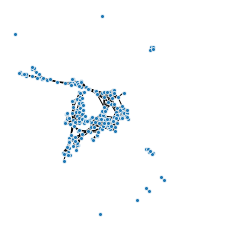

In [5]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Pregnancies', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[times pregnant vs. glucose](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[times pregnant vs. glucose](perc_overlap=0.5, n_clusters = 2).html")



import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## bloodpressure vs. glucose_tol

### perc_overlap=0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_7 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_26 is empty.

Cube_27 i

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clu

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


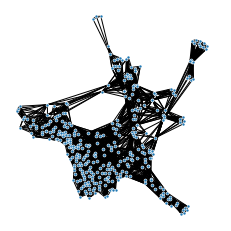

In [20]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BloodPressure', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_4 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_10 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_15 is empty.

Cube_16 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > F

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


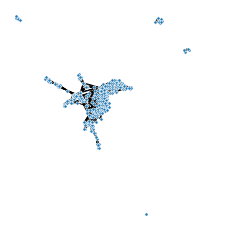

In [17]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BloodPressure', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_13 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

   > Found 2 clusters.

Cube_20 is empty.

Cube_21 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_27 is empty.

Cube_28 is empty.

Cube_29 is empty

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


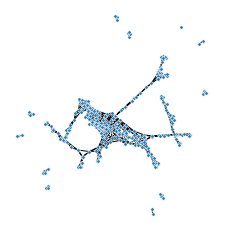

In [5]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BloodPressure', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.4, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_8 is empty.

   > Found 2 clusters.

Cube_10 is empty.

Cube_11 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

   > Found 2 clusters.

Cube_3

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


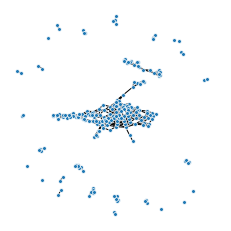

In [18]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BloodPressure', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.4),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.3, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 1 clusters.

   > Found 2 clusters.

Cube_3 is empty.

   > Found 1 clusters.

   > Found 2 clusters.

Cube_6 is empty.

   > Found 2 clusters.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_18 is empty.

   > Found 2 clusters.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

   > Found 2 clusters.

Cube_26 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_29 is empty.

   > Found 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_44 is empty.

Cube_45 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_53 is empty.

Cube_54 is empty.

Cube_55 is empty.

Cube_56 is empty.

Cube_57 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_62 is empty.

Cube_63 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_67 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clust

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


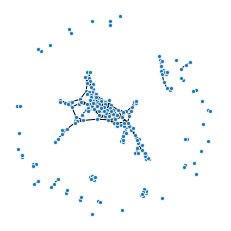

In [19]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BloodPressure', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.3),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[bloodpressure vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## SkinThickness vs. glucose_tol

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

   > Found 2 clusters.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_28 is empty.

Cube_29 is empty.

Cube_30 is empty.

   > Fou

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


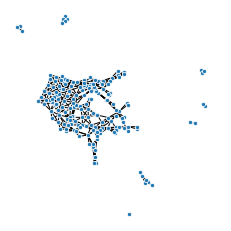

In [6]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['SkinThickness', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[SkinThickness vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[SkinThickness vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## insulin vs. glucose_tol

### perc_overlap=0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_22 is empty.

Cube_23 is empty.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_32 is empty.

Cube_33 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_41 is empty.

Cube_42 is empty.

Cube_43 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clus

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


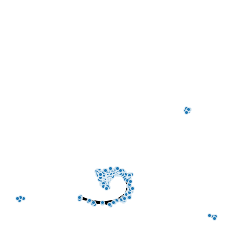

In [15]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_6 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_11 is empty.

Cube_12 is empty.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_18 is empty.

   > Found 1 clusters.

Cube_20 is empty.

Cube_21 is empty.

   > Found 2 clusters.

   > Found 2 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_31 is empty.

Cube_32 is empty.

Cube_33 is empty.

Cube_34 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


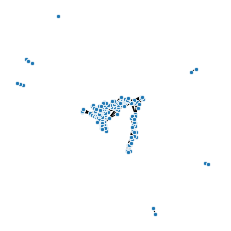

In [16]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

   > Found 2 clusters.

Cube_6 is empty.

   > Found 2 clusters.

Cube_8 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_11 is empty.

   > Found 1 clusters.

Cube_13 is empty.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_17 is empty.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clus

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

Cube_34 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_57 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_71 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


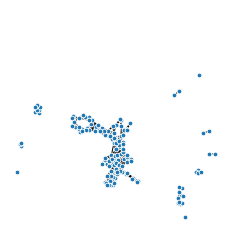

In [7]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.4, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 2 clusters.

Cube_7 is empty.

   > Found 2 clusters.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_17 is empty.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


Created 284 edges and 125 nodes in 0:00:01.851757.
Wrote visualization to: diabetes-[insulin vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


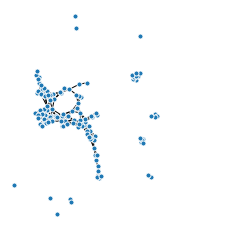

In [17]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.4),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.3, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

   > Found 1 clusters.

Cube_6 is empty.

   > Found 2 clusters.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 2 clusters.

Cube_14 is empty.

Cube_15 is empty.

   > Found 2 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_21 is empty.

Cube_22 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_36 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_51 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


Created 203 edges and 106 nodes in 0:00:01.390087.
Wrote visualization to: diabetes-[insulin vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


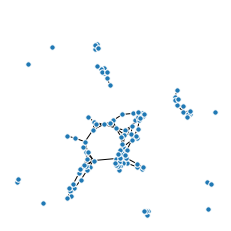

In [18]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.3),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[insulin vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## BMI vs. glucose_tol

### perc_overlap=0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

   > Found 2 clus

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


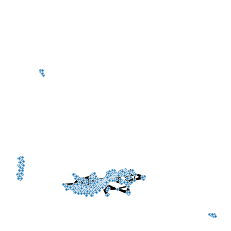

In [6]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BMI', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_16 is empty.

Cube_17 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 i

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


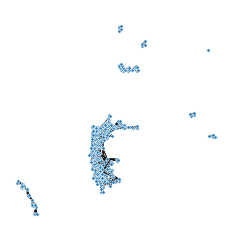

In [12]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BMI', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_6 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

Cube_23 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


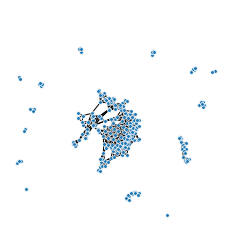

In [8]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BMI', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.4, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_23 is empty.

Cube_24 is empty.

   > Found 2 clusters.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

Cube_29 is empty.

Cub

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


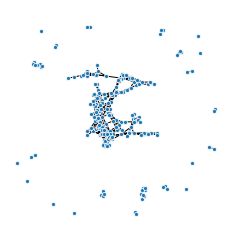

In [13]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BMI', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.4),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.3, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_11 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_21 is empty.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

   > Found 2 clusters.

Cube_29 is empty.

   > Found 2

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


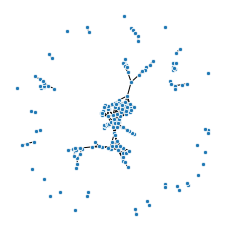

In [14]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['BMI', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.3),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BMI vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## pedigree vs. glucose_tol

### perc_overlap=0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_22 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   

Wrote visualization to: diabetes-[pedigree vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


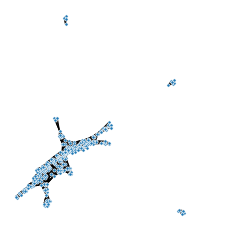

In [4]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['DiabetesPedigreeFunction', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_22 is empty.

   > Found 2 clusters.

Cube_24 is empty.

   > Found 2 clusters.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

Cube_29 is empty.

Cube_30

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


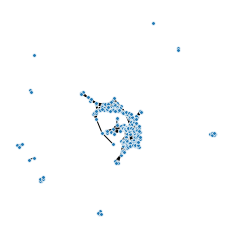

In [5]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['DiabetesPedigreeFunction', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 2 clusters.

Cube_7 is empty.

   > Found 2 clusters.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

   > Found 2 clusters.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

   > Found 2 clusters.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

   > Found 2 clusters.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

Cube_29 is empty.

Cube_30 is empty.

   > Found 2 

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


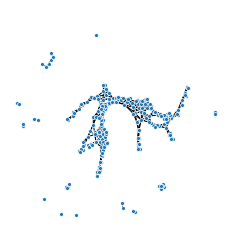

In [9]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['DiabetesPedigreeFunction', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.4, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

   > Found 2 clusters.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

   > Found 2 clusters.

Cube_24 is empty.

   > Found 2 clusters.

Cube_26 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_29 is empty.

   > Found 2 clusters.

   >

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


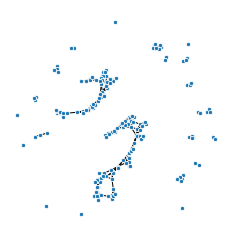

In [6]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['DiabetesPedigreeFunction', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.4),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.3, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 2 clusters.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

   > Found 2 clusters.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

   > Found 2 clusters.

Cube_23 is empty.

Cube_24 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_27 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_30 is empty.

   > Found

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


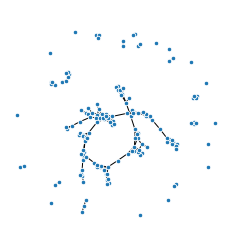

In [7]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['DiabetesPedigreeFunction', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.3),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[pedigree vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## age vs. glucose_tol

### perc_overlap=0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_15 is empty.

Cube_16 is empty.

   > Found 2 clusters.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_22 is empty.

Cube_23 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_26 is empty.

Cube_27 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


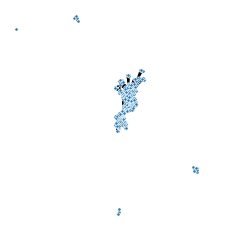

In [8]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Age', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_11 is empty.

Cube_12 is empty.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

Cube_16 is empty.

   > Found 2 clusters.

Cube_18 is empty.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_26 is empty.

Cube_27 is empty.

   > Found 2 clusters.

Cube_29 is empt

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


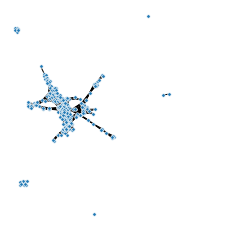

In [9]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Age', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

   > Found 1 clusters.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_15 is empty.

   > Found 2 clusters.

Cube_17 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_21 is empty.

   > Found 2 clusters.

Cube_23 is empty.

Cube_24 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

Cube_33 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_36 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_45 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_58 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Wrote visualization to: diabetes-[age vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


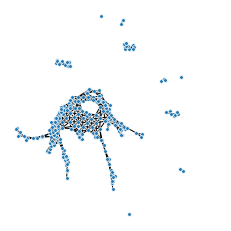

In [10]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Age', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.4, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

Cube_16 is empty.

Cube_17 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_20 is empty.

Cube_21 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_26 is empty.

   > Found 2 clusters.

Cube_28 is empty.

   > Found 2 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


Created 507 edges and 215 nodes in 0:00

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


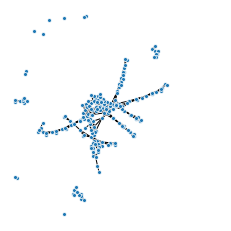

In [10]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Age', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.4),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.4, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap=0.3, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_10 is empty.

   > Found 2 clusters.

Cube_12 is empty.

Cube_13 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_16 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_20 is empty.

Cube_21 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

C

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


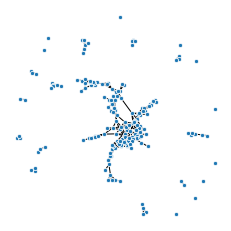

In [11]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Age', 'Glucose']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.3),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[age vs. glucose_tol](perc_overlap=0.3, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## times pregnant vs. insulin

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

   > Found 2 clusters.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_16 is empty.

Cube_17 is empty.

   > Found 2 clusters.

Cube_19 is empty.

Cube_20 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_40 is empty.

Cube_41 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_48 is empty.

Cube_49 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_54 is empty.

   > Found 1 clusters.

Cube_56 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_81 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


Created 364 edges and 158 nodes in 0:00:01.032302.
Wrote visualization to: diabetes-[times pregnant vs. insulin](perc_overlap=0.5, n_cluster

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


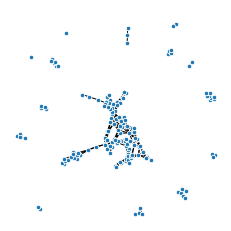

In [11]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'Pregnancies']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[times pregnant vs. insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[times pregnant vs. insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## BloodPressure vs. insulin

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

   > Found 2 clusters.

Cube_6 is empty.

Cube_7 is empty.

   > Found 2 clusters.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_17 is empty.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_54 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_58 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

  

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


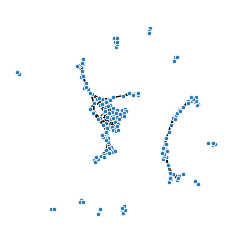

In [12]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'BloodPressure']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure vs. insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure vs. insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## SkinThickness vs. insulin

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

   > Found 2 clusters.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_28 is empty.

Cube_29 is empty.

   > Found 2 c

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_55 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_58 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_71 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_85 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


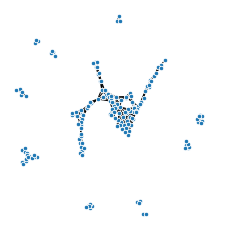

In [13]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'SkinThickness']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[SkinThickness vs. insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[SkinThickness vs. insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## BMI vs. insulin

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

   > Found 2 clusters.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

   > Found 2 clusters.

Cube_13 is empty.

Cube_14 is empty.

   > Found 2 clusters.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_27 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 cluster

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


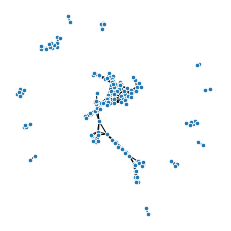

In [14]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'BMI']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BMI vs. insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BMI vs. insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## pedigree vs. insulin

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

   > Found 2 clusters.

Cube_15 is empty.

Cube_16 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_20 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_30 is empty.

Cu

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


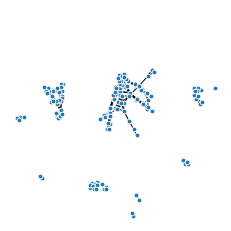

In [15]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'DiabetesPedigreeFunction']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[pedigree vs. insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[pedigree vs. insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## age vs. insulin

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (768, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (768, 2) using lens shaped (768, 2)

Minimal points in hypercube before clustering: 2
Creating 225 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_15 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_24 is empty.

Cube_25 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


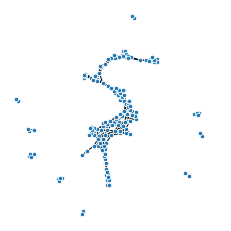

In [16]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in data.columns if c in ['Insulin', 'Age']]
X = np.array(data[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=15, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[age vs. insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[age vs. insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

위의 그래프들을 살펴보면 BloodPressure vs. glucose_tol, BMI vs. glucose tol, pedigree vs. glucose tol, age vs. glucose tol 인 경우에만 어느 정도 정확한 clustering을 형성하는 것을 알 수 있다. 기본적으로 data의 분포를 보면 파악할 수 있겠지만 data가 아주 많은 noise를 가지고 있기 때문에 정확한 clustering을 기대할 수 없다. 따라서, 대략 위 4가지 경우만을 가지고 어느 정도 정확하게 diabetes 여부를 판단할 수 있을 것으로 생각된다. 그러나 의외로 검사 비용이 제일 많이 드는 glucose tol 검사와 insulin 검사의 조합은 그리 정확한 clustering을 형성하지 못하는 것을 발견하였다.

k-mapper를 이용해서 Pima Indian diabetes data를 분석해 보았다. diabetes를 판단하기 위해서 최선의 방법은 8가지의 검사 결과를 모두 이용해서 분석을 하는 것이겠지만, 실험 결과를 보면 Plasma glucose concentration a 2 hours on oral glucose tolerance test와 Diastolic blood pressure test, BMI, Diabetes pedigree function test, age 등의 결과만을 가지고도 만족할 만한 classification을 할 수 있을 것으로 생각된다. 5가지의 검사만으로도 결과를 얻을 수 있고, 또한 많은 비용을 필요로 하는 2-Hour serum insulin test가 정확도에 끼치는 영향이 그리 크지 않은 것으로 보여진다.

## BloodPressure + SkinThickness + Insulin 기준( train_X의 이상치 제거 data가지고 실행)

Outcome과 가장 낮은 선형 상관 관계를 가지는 세가지 feature들이고 로지스틱 회귀와 xgboost에서 가장 덜 중요한 feature로 판단되었으므로 이 기준으로 실행한 kmapper와 다른 기준들로 실행한 kmapper를 비교한다.

### perc_overlap = 0.5, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clus

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_151 is empty.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

Cube_154 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_164 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_170 is empty.

   > Found 3 clusters.

   > Found 4 clusters.

   > Found 3 clusters.

Cube_174 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 4 clusters.

   > Found 2 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

Cube_190 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 1 clusters.


Created 1349 edges and 529 nodes in 0:00:05.136776.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 4).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


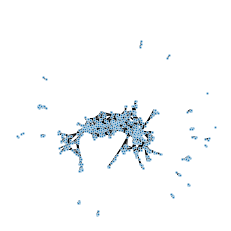

In [40]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.6, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

Cube_18 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Fo

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

Cube_173 is empty.

Cube_174 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 3 clusters.

Cube_184 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

Cube_203 is empty.

Cube_204 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_209 is empty.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



Created 3715 edges and 624 nodes in 0:00:03.874636.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 4).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


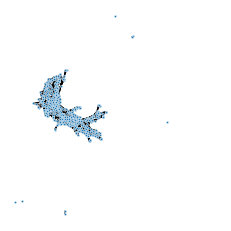

In [41]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.7, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_171 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

Cube_184 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_196 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 2 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 1 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 1 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 3 clusters.

Cube_237 is empty.


Created 9817 edges and 765 nodes in 0:00:04.547648.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 4).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


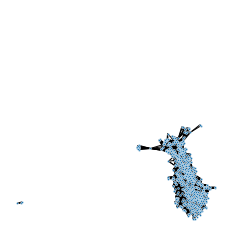

In [42]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.8, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_7 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_15 is empty.

Cube_16 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

   > Fou

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

Cube_225 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_238 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 2 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 3 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 2 clusters.


Created 31299 edges and 968 nodes in 0:00:06.648071.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 4).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


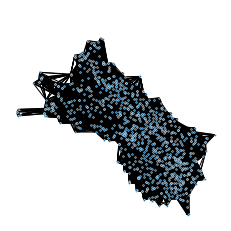

In [43]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.5, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

   > Found 3 clusters.

Cube_8 is empty.

Cube_9 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 2 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

Cube_154 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

   > Found 3 clusters.

   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

Cube_190 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.


Created 1238 edges and 442 nodes in 0:00:03.850776.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 3).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


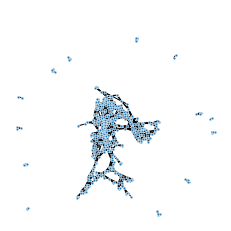

In [44]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.6, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

   > Found 3 clusters.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

   > Found 3 clusters.

Cube_9 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_16 is empty.

Cube_17 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

   > Found 3 clust

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_149 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_173 is empty.

Cube_174 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

Cube_203 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 3 clusters.

   > Found 3 clusters.

Cube_209 is empty.


Created 3385 edges and 507 nodes in 0:00:03.143755.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 3).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


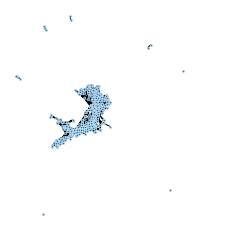

In [45]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.7, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Fo

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_237 is empty.


Created 8590 edges and 619 nodes in 0:00:03.933377.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 3).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


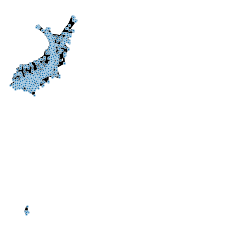

In [46]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.8, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_7 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_15 is empty.

Cube_16 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empt

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 1 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 2 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 2 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



Created 25778 edges and 752 nodes in 0:00:05.551591.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 3).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


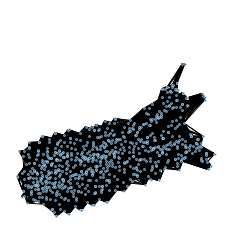

In [47]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_8 is empty.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_15 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Fou

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clu

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_190 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 1 clusters.


Created 1072 edges and 336 nodes in 0:00:02.080568.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 2).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


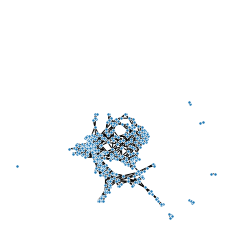

In [48]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_5 is empty.

Cube_6 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_16 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

   > Found 2 c

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 1 clusters.

Cube_203 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

Cube_209 is empty.


Created 2786 edges and 366 nodes in 0:00:02.324916.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 2).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


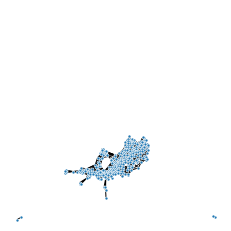

In [49]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_22 is empty.

Cube_23 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

  

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 1 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 1 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



Created 6831 edges and 435 nodes in 0:00:03.129873.
Wrote visualization to: diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 2).html


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


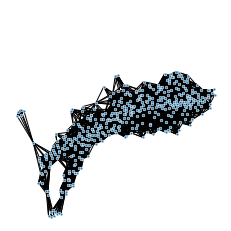

In [50]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.8, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_7 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_15 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_25 is empty.

Cube_26 is empty.

   >

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_



   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


Created 18922 edges and 521 nodes in 0:00:04.219739.
Wrote visualization to: diabetes-

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


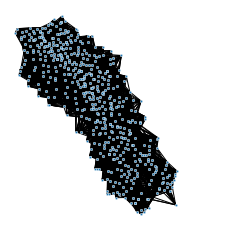

In [51]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.5, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


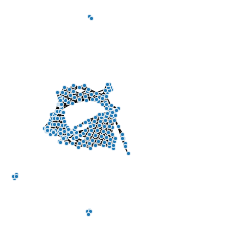

In [52]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.5, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.6, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


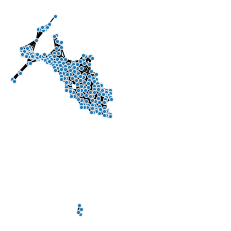

In [53]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.6, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.7, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


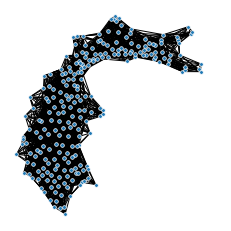

In [54]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.7, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.8, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 3)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 3) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


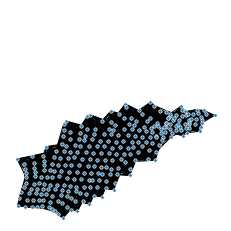

In [55]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['SkinThickness', 'Insulin', 'BloodPressure']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[BloodPressure + SkinThickness + Insulin](perc_overlap=0.8, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## Except SkinThickness, Insulin( train_X의 이상치 제거 data가지고 실행)

로지스틱 회귀와 xgboost에서 공통으로 생각되는 덜 중요한 기능 두 개인 SkinThickness와 Insulin을 제외한뒤 kmapper를 실행시킴

###  perc_overlap = 0.5, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_24 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


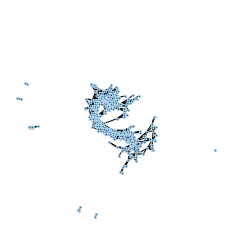

In [45]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.6, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_17 is empty.

Cube_18 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_24 is empty.

Cube_25 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Foun

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


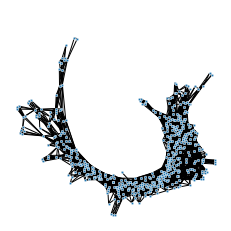

In [46]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.7, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_8 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_14 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_21 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > 

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


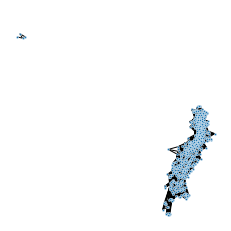

In [47]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.8, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_6 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_13 is empty.

Cube_14 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_21 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clu

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


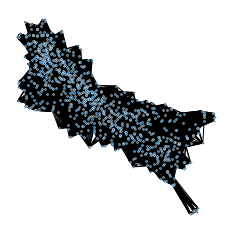

In [48]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.5, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_11 is empty.

Cube_12 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_24 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 cluste

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


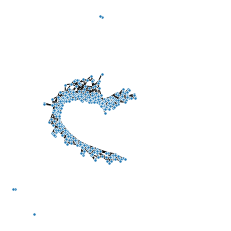

In [26]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.6, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 3 clusters.

Cube_3 is empty.

Cube_4 is empty.

   > Found 3 clusters.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_18 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_24 is empty.

Cube_25 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clu

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


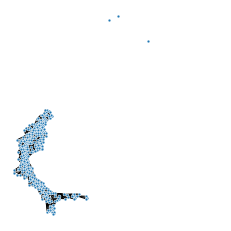

In [27]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.7, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_3 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_8 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_14 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_21 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


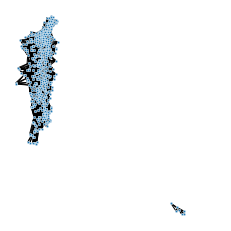

In [28]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.8, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_6 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_13 is empty.

Cube_14 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_21 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


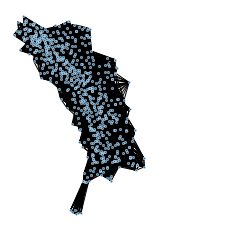

In [29]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

   > Found 2 clusters.

Cube_5 is empty.

Cube_6 is empty.

   > Found 2 clusters.

Cube_8 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


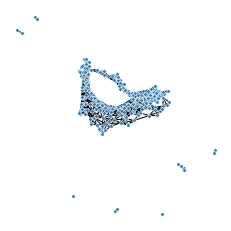

In [30]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_3 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_18 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_25 is empty.

   > Found 2 clusters.

   > 

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


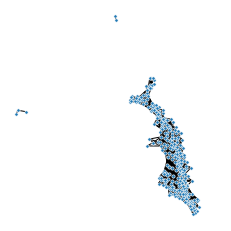

In [31]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_21 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


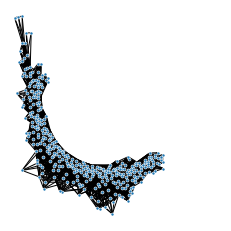

In [32]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.8, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_6 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_13 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_21 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


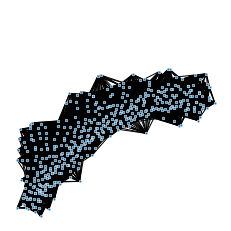

In [33]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.5, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


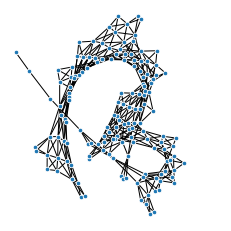

In [34]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.5, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.6, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


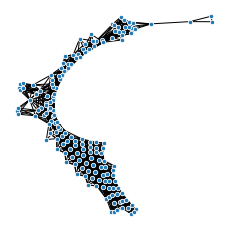

In [35]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.6, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.7, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


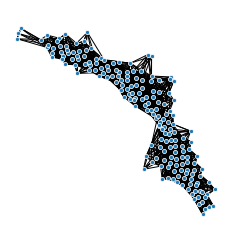

In [36]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.7, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.8, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 6)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 6) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


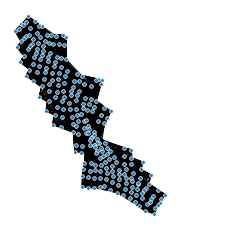

In [37]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c not in ['SkinThickness', 'Insulin']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[Except SkinThickness, Insulin](perc_overlap=0.8, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

## glucose + BMI 기준( train_X의 이상치 제거 data가지고 실행)
포도당과 BMI는 로지스틱 회귀 (l1 및 l2 포함) 및 xgboost에 가장 중요한 feature로 나타났습니다. 이 결과는 상관 행렬과 일치합니다

###  perc_overlap = 0.5, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

   > Found 4 clusters.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

Cube_19 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_33 is empty.

Cube_34 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_40 is empty.

Cube_41 is empty.

Cube_42 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_49 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_63 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


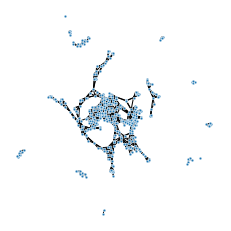

In [41]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])


# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.6, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

   > Found 4 clusters.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

Cube_23 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

Cube_32 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_39 is empty.

Cube_40 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_47 is empty.

Cube_48 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_70 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


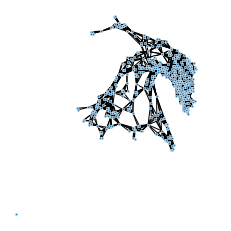

In [42]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.7, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_9 is empty.

   > Found 4 clusters.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_20 is empty.

Cube_21 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Fou

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


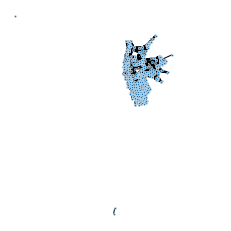

In [43]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])



# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 4).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

###  perc_overlap = 0.8, n_clusters = 4

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 4
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_7 is empty.

Cube_8 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_16 is empty.

Cube_17 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_27 is empty.

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


   > Found 3 clusters.

Cube_60 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

Cube_81 is empty.

Cube_82 is empty.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Found 4 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


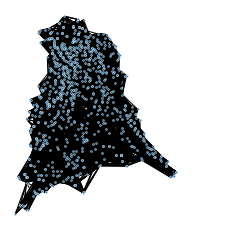

In [44]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 4).html",
                       custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 4).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.5, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


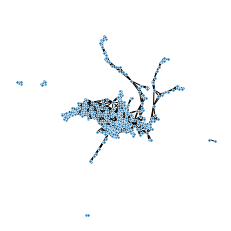

In [49]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])


# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.6, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 3 clusters.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_23 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

  

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


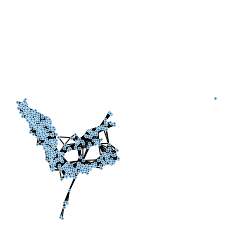

In [50]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.7, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

   > Found 3 clusters.

Cube_3 is empty.

   > Found 3 clusters.

Cube_5 is empty.

Cube_6 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_11 is empty.

Cube_12 is empty.

Cube_13 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_20 is empty.

Cube_21 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 c

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


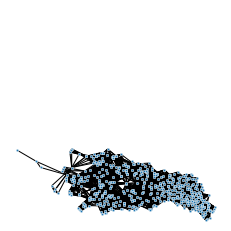

In [51]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])



# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 3).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.8, n_clusters = 3

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_7 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_16 is empty.

Cube_17 is empty.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

   > Found 3 clusters.

Cube_

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


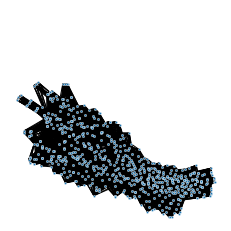

In [52]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 3).html",
                       custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 3).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.5, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

Cube_2 is empty.

Cube_3 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_6 is empty.

Cube_7 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_11 is empty.

Cube_12 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


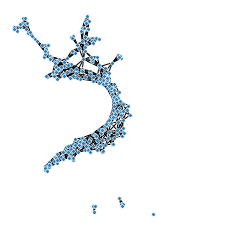

In [53]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])


# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.6, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_5 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_9 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_14 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_23 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


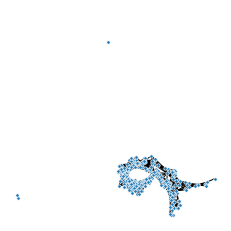

In [54]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.7, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
Cube_0 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_12 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clust

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


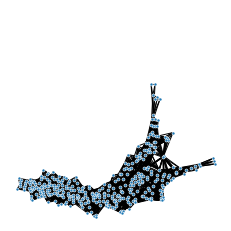

In [55]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])



# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 2).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.8, n_clusters = 2

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_7 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

Cube_16 is empty.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clusters.

   > Found 2 clust

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


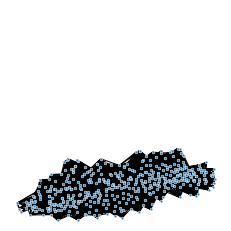

In [56]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 2).html",
                       custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 2).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.5, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


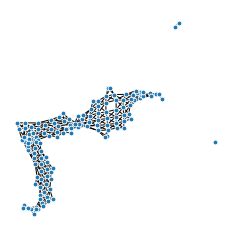

In [57]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])


# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.5),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.5, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.6, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


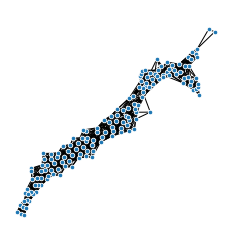

In [58]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.6),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.6, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.7, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


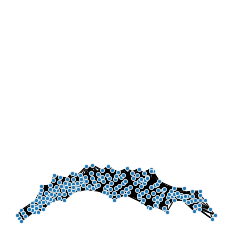

In [59]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble


feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])



# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.7),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 1).html", custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.7, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()

### perc_overlap = 0.8, n_clusters = 1

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (576, 2)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()

Mapping on data shaped (576, 2) using lens shaped (576, 2)

Minimal points in hypercube before clustering: 1
Creating 400 hypercubes.
   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Fo

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


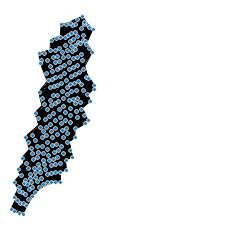

In [60]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with `pip install pandas` and then try again.")
    sys.exit()

import numpy as np
import kmapper as km
import sklearn
from sklearn import ensemble



feature_names = [c for c in train_X.columns if c in ['Glucose', 'BMI']]
X = np.array(train_X[feature_names])  # quick and dirty imputation
y = np.array(data["Outcome"])

# We create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# We create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=2)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Create the simplicial complex
graph = mapper.map(lens,
                   X,
                   cover=km.Cover(n_cubes=20, perc_overlap=0.8),
                   clusterer=sklearn.cluster.KMeans(n_clusters=1,
                                                    random_state=9999))

# Visualization
from kmapper import jupyter
html = mapper.visualize(graph, path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 1).html",
                       custom_tooltips=y)
jupyter.display(path_html="diabetes-[glucose + BMI](perc_overlap=0.8, n_clusters = 1).html")





import matplotlib.pyplot as plt
km.draw_matplotlib(graph)
plt.show()